<a href="https://colab.research.google.com/github/sean-metzger/code_examples/blob/master/vaes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 745, done.
remote: Total 745 (delta 0), reused 0 (delta 0), pack-reused 745
Receiving objects: 100% (745/745), 83.53 MiB | 25.77 MiB/s, done.
Resolving deltas: 100% (347/347), done.
--2020-03-18 23:41:25--  https://docs.google.com/uc?export=download&confirm=qfHQ&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.113, 74.125.195.102, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-5c-docs.googleusercontent.com/docs/securesc/bpnnbgt0pkdfpmrv2cb6f6g6hgrcds2v/j0bsbd5a0nmnjd2fgb931g57rh7l5vuk/1584574875000/06419056966375271799/03898145480704870023Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-03-18 23:41:25--  https://doc-10-5c-docs.googleusercontent.com/docs/securesc/bpnnbgt0pkdfpmrv2cb6f6g6hgrcds2v/j0bsbd5a0nmnjd2fgb931g57rh7l5vuk/1584

In [ ]:
from deepul.hw3_helper import *

In [ ]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


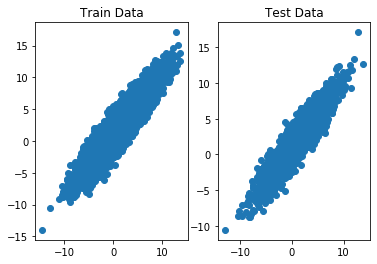

Dataset 2


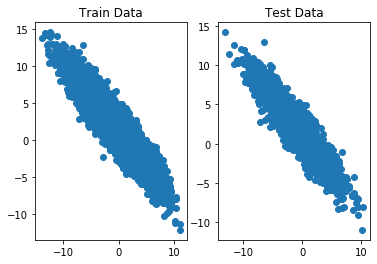

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
out = 2
inp = 2

class encoder(nn.Module): 
  def __init__(self):
    super(encoder, self).__init__()
    self.lay = nn.Linear(inp, out)
    self.lay2 = nn.Linear(out, out)
    self.varlay = nn.Linear(inp, out)
    self.varlay2 = nn.Linear(out, out) 

  def forward(self, x): 
    mu = F.relu(self.lay(x))
    mu = self.lay2(mu)
    logvar = F.relu(self.varlay(x))
    logvar = self.varlay2(logvar)
    return mu, logvar

class decoder(nn.Module): 
  def __init__(self):
    super(decoder, self).__init__()
    self.lay = nn.Linear(out, out)
    self.lay2 = nn.Linear(out, inp)
    self.layvar = nn.Linear(out, out)
    self.layvar2 = nn.Linear(out, inp)

  def forward(self, z): 
    recon = F.relu(self.lay(z))
    recon = self.lay2(recon)
    reconvar = F.relu(self.layvar(z))
    reconvar = self.layvar2(reconvar)
    return recon, reconvar

class VAE(nn.Module): 
  def __init__(self):
    super(VAE, self).__init__()
    self.enc = encoder()
    self.dec= decoder()

  def repam(self, mu, log_var):
    var = torch.exp(.5*log_var)
    z = mu + var*torch.randn(mu.shape).cuda()
    return z

  def forward(self, x): 
    mu, log_var = self.enc(x)
    z = self.repam(mu, log_var)
    dec_mu, dec_var = self.dec(z)
    return mu, log_var, dec_mu, dec_var

  def loss(self, x, mu, log_var, dec_mu, dec_log_var): 
    var = torch.exp(log_var)
    dec_var = torch.exp(dec_log_var)
    logexp = ((x-dec_mu)**2)*(1/dec_var)
    logexp = -.5*torch.sum(logexp, 1)
    denom = .5*torch.sum(dec_log_var,1)
    recon_loss = logexp - denom
    recon_loss = -1*torch.sum(logexp-denom - torch.log(torch.tensor(2*np.pi))) 
    KL_loss = -.5*torch.sum(1 + log_var - mu*mu - torch.exp(log_var))
    KL_loss = torch.sum(KL_loss)
    recon_loss = torch.sum(recon_loss)
    return (recon_loss + KL_loss)/x.shape[0]

  def get_elbo_recon_kl(self, x, mu, log_var, dec_mu, dec_log_var):
    var = torch.exp(log_var)
    dec_var = torch.exp(dec_log_var)
    logexp = (x-dec_mu)*(1/dec_var)*(x-dec_mu)
    logexp = -.5*torch.sum(logexp, 1)
    denom = .5*torch.sum(dec_log_var,1)
    # print(denom.shape, logexp.shape)
    recon_loss = logexp - denom
    recon_loss = -1*torch.sum(logexp-denom - torch.log(torch.tensor(2*np.pi))) 
    KL_loss = -.5*torch.sum(1 + log_var - mu**2 - torch.exp(log_var))
    KL_loss = torch.sum(KL_loss)
    recon_loss = torch.sum(recon_loss)
    return (recon_loss + KL_loss)/x.shape[0], recon_loss/x.shape[0], KL_loss/x.shape[0]


  def get_noisy_samples(self): 
    s= torch.randn(1000, out).cuda()
    mean, logvar = self.dec(s)
    n = torch.distributions.normal.Normal(mean, torch.exp(logvar))

    n = n.sample()
    print(mean.shape, n.shape, logvar.shape)
    return mean, n



In [ ]:
quiet = False

def train(model, train_loader, optimizer, epoch): 
  model.train()
  train_losses = []
  for x in train_loader: 
    x = x.cuda().contiguous()
    mu, log_var, dec_mu, dec_var = model(x)
    loss = model.loss(x, mu, log_var, dec_mu, dec_var)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu, dec_var)
    ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
    train_losses.append(ish)
  return train_losses

def eval_loss(model, data_loader): 
  model.eval()
  total_loss = np.zeros(3)
  with torch.no_grad(): 
    for x in data_loader: 
      x = x.cuda().contiguous()
      mu, log_var, dec_mu, dec_var = model(x)
      ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu, dec_var)
      ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
      total_loss += ish*x.shape[0]
    avg_loss = total_loss/len(data_loader.dataset)

  return avg_loss

def train_epochs(model, train_loader, test_loader, train_args): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  init_loss = eval_loss(model, test_loader)
  print('init loss', init_loss)
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs): 
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet: 
      print(f'Epoch {epoch}, Test loss', test_loss)
  return train_losses, test_losses

In [ ]:
def q1(train_data, test_data, part, dset_id):
  """
  train_data: An (n_train, 2) numpy array of floats
  test_data: An (n_test, 2) numpy array of floats

  (You probably won't need to use the two inputs below, but they are there
    if you want to use them)
  part: An identifying string ('a' or 'b') of which part is being run. Most likely
        used to set different hyperparameters for different datasets
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
  - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
  - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
  - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
  """



  """ YOUR CODE HERE """ 
  train_data = torch.tensor(train_data).float()
  test_data = torch.tensor(test_data).float()
  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)


  # model
  model = VAE()
  model = model.cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader,test_loader, 
                                          dict(epochs=10, lr=1e-2))
  
  clean_samps, noisy_samps = model.get_noisy_samples()
  clean_samps = clean_samps.detach().cpu().numpy()
  noisy_samps = noisy_samps.detach().cpu().numpy()

  return np.asarray(train_losses), np.asarray(test_losses), noisy_samps, clean_samps

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

init loss [30.76348008 27.40712227  3.3563578 ]
Epoch 0, Test loss [6.09702952 4.78323405 1.31379548]
Epoch 1, Test loss [5.41384326 4.92173993 0.49210328]
Epoch 2, Test loss [5.3647583  5.0016188  0.36313953]
Epoch 3, Test loss [5.32969463 4.92802629 0.40166831]
Epoch 4, Test loss [5.3066329  4.84442131 0.46221159]
Epoch 5, Test loss [5.2895332  4.77739639 0.5121368 ]
Epoch 6, Test loss [5.22778492 4.64454426 0.58324073]
Epoch 7, Test loss [5.18324587 4.47540258 0.7078433 ]
Epoch 8, Test loss [5.08105906 4.20218008 0.87887895]
Epoch 9, Test loss [5.03997463 4.10846907 0.93150552]
torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final -ELBO: 5.0400, Recon Loss: 4.1085, KL Loss: 0.9315


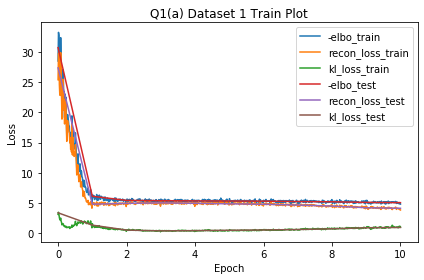

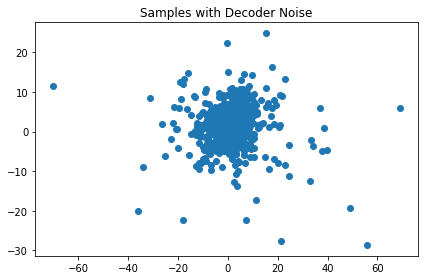

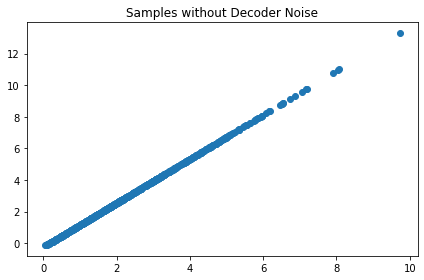

In [ ]:
q1_save_results('a', 1, q1)

init loss [29.50896904 28.27596748  1.23300166]
Epoch 0, Test loss [8.3620312  6.80427098 1.55776018]
Epoch 1, Test loss [6.34929764 5.06710725 1.28219045]
Epoch 2, Test loss [5.77860286 4.58676477 1.19183813]
Epoch 3, Test loss [5.47629403 4.33803685 1.1382571 ]
Epoch 4, Test loss [5.24076729 4.14023367 1.10053359]
Epoch 5, Test loss [5.11997374 4.04793895 1.07203478]
Epoch 6, Test loss [5.02037291 4.00181478 1.01855815]
Epoch 7, Test loss [4.9731472  3.93544191 1.0377053 ]
Epoch 8, Test loss [4.93281896 3.86154719 1.07127174]
Epoch 9, Test loss [4.91156057 3.91336581 0.99819475]
torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final -ELBO: 4.9116, Recon Loss: 3.9134, KL Loss: 0.9982


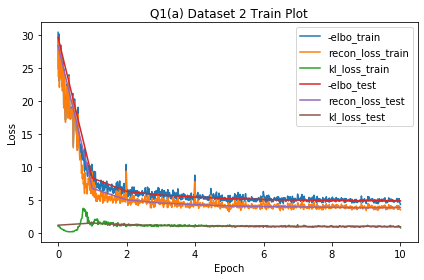

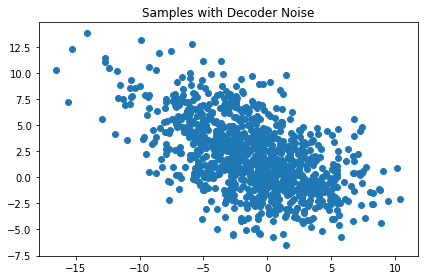

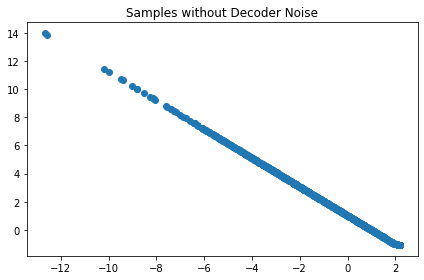

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


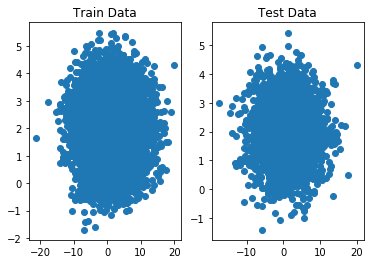

Dataset 2


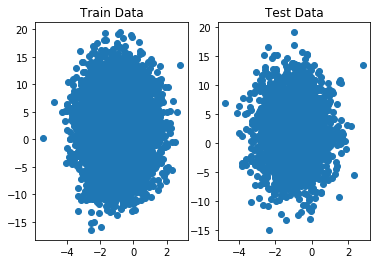

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

init loss [11.40466809 10.52801924  0.87664889]
Epoch 0, Test loss [5.48711372 5.04412611 0.44298757]
Epoch 1, Test loss [4.68639092 4.49086125 0.19552964]
Epoch 2, Test loss [4.47512849 4.33560225 0.13952625]
Epoch 3, Test loss [4.4396916  4.34960361 0.09008803]
Epoch 4, Test loss [4.42520022 4.36111035 0.06408985]
Epoch 5, Test loss [4.42933281 4.38751964 0.04181318]
Epoch 6, Test loss [4.42670247 4.39741428 0.02928823]
Epoch 7, Test loss [4.41506914 4.39170762 0.02336155]
Epoch 8, Test loss [4.42255529 4.40566885 0.01688645]
Epoch 9, Test loss [4.42118514 4.40736224 0.01382285]
torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final -ELBO: 4.4212, Recon Loss: 4.4074, KL Loss: 0.0138


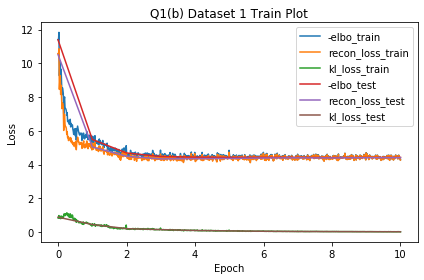

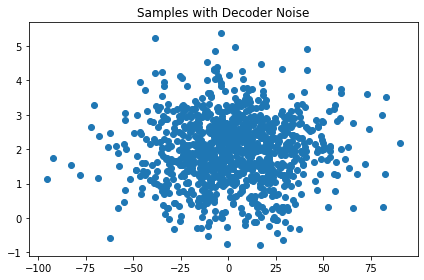

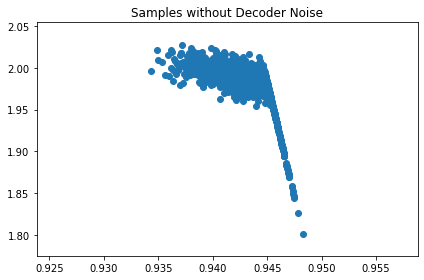

In [ ]:
q1_save_results('b', 1, q1)

init loss [20.41662251 18.17583086  2.24079161]
Epoch 0, Test loss [5.58511389 5.17749204 0.40762185]
Epoch 1, Test loss [4.7385235  4.55482582 0.18369769]
Epoch 2, Test loss [4.54113638 4.4354379  0.10569846]
Epoch 3, Test loss [4.47804078 4.42214255 0.05589824]
Epoch 4, Test loss [4.44847372 4.41900461 0.0294691 ]
Epoch 5, Test loss [4.43575947 4.41872744 0.01703203]
Epoch 6, Test loss [4.43189497 4.41966641 0.01222854]
Epoch 7, Test loss [4.4253264  4.4177109  0.00761551]
Epoch 8, Test loss [4.42315459 4.41836323 0.0047913 ]
Epoch 9, Test loss [4.42161833e+00 4.41977947e+00 1.83883604e-03]
torch.Size([1000, 2]) torch.Size([1000, 2]) torch.Size([1000, 2])
Final -ELBO: 4.4216, Recon Loss: 4.4198, KL Loss: 0.0018


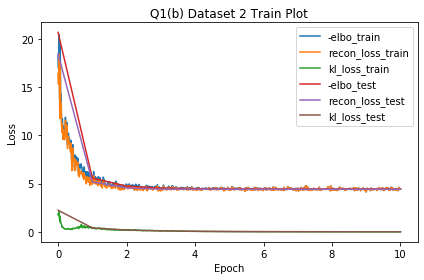

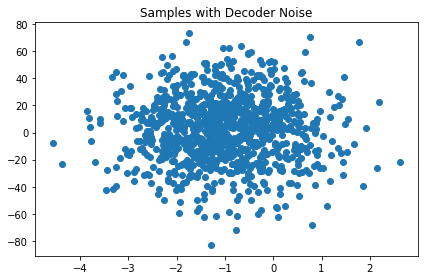

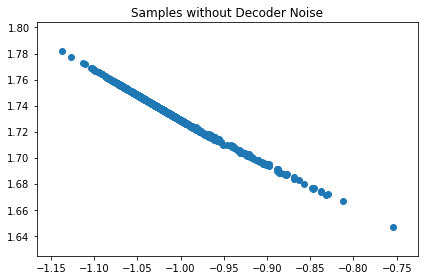

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without latents in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

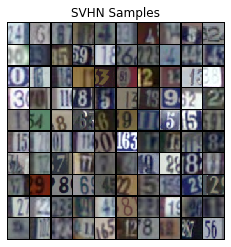

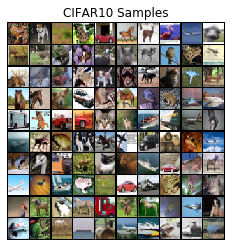

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
latent_dim = 16
class encoder(nn.Module): 
  def __init__(self):
    super(encoder, self).__init__()
    self.c1 = nn.Conv2d(3, 32, 3, 1, 1)
    self.c2 = nn.Conv2d(32, 64, 3, 2, 1) # 16 x 16
    self.c3 = nn.Conv2d(64, 128, 3, 2, 1) # 8 x 8
    self.c4 = nn.Conv2d(128, 256, 3, 2, 1) # 4 x 4
    convs = [self.c1, self.c2, self.c3, self.c4]
    self.convs = nn.ModuleList(convs)
    self.final = nn.Linear(4*4*256, 2*latent_dim)

  def forward(self, x): 
    for conv_layer in self.convs: 
      x = F.relu(conv_layer(x))
    x = torch.flatten(x, start_dim=1)
    z = self.final(x)
    mu = z[:, :latent_dim]
    logvar = z[:, latent_dim:]
    return mu, logvar

class decoder(nn.Module): 
  def __init__(self):
    super(decoder, self).__init__()
    # linear(latent_dim, 4 * 4 * 128)
    # relu()
    # reshape(4, 4, 128)
    # transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    # relu()
    # transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    # relu()
    # transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    # relu()
    # conv2d(32, 3, 3, 1, 1)
    self.L = nn.Linear(latent_dim, 4*4*128)
    self.trans1 = nn.ConvTranspose2d(128, 128, 4, 2, 1) #8, 8
    self.trans2 = nn.ConvTranspose2d(128, 64, 4, 2, 1) #16, 16
    self.trans3 = nn.ConvTranspose2d(64, 32, 4, 2, 1) # 32, 32
    self.outconv = nn.Conv2d(32, 3, 3, 1, 1)

  def forward(self, z): 
    x = F.relu(self.L(z))
    x = x.contiguous().view(x.shape[0], 128, 4, 4)
    x = F.relu(self.trans1(x))
    x = F.relu(self.trans2(x))
    x = F.relu(self.trans3(x))
    x = F.tanh(self.outconv(x)) # go between -1, 1
    return x

class VAE(nn.Module): 
  def __init__(self):
    super(VAE, self).__init__()
    self.enc = encoder()
    self.dec= decoder()
    self.mse = nn.MSELoss(size_average=False, reduce=False, reduction='none')

  def repam(self, mu, log_var):
    var = torch.exp(.5*log_var)
    z = mu + var*torch.randn(mu.shape).cuda()
    return z

  def forward(self, x): 
    mu, log_var = self.enc(x)
    z = self.repam(mu, log_var)
    dec_mu = self.dec(z)
    return mu, log_var, dec_mu

  def loss(self, x, mu, log_var, dec_mu):  
    KL_loss = -.5*torch.sum(1 + log_var - mu*mu - torch.exp(log_var))
    KL_loss = torch.sum(KL_loss)/x.shape[0]
    recon_loss = self.mse(x, dec_mu)
    recon_loss = torch.sum(recon_loss)/x.shape[0]
    loss = KL_loss + recon_loss
    return loss

  def get_elbo_recon_kl(self, x, mu, log_var, dec_mu):
    KL_loss = -.5*torch.sum(1 + log_var - mu*mu - torch.exp(log_var))
    KL_loss = torch.sum(KL_loss)/x.shape[0]
    recon_loss = self.mse(x, dec_mu)
    recon_loss = torch.sum(recon_loss)/x.shape[0]
    loss = KL_loss + recon_loss
    return loss, recon_loss, KL_loss

  def get_samples(self): 
    s= torch.randn(100, latent_dim).float().cuda()
    return self.dec(s)


  def get_test_samples(self, x): 
    x = x.float().cuda()
    mu, log_var = self.enc(x)
    z = self.repam(mu, log_var)
    dec_mu = self.dec(z)
    dec_mu = torch.stack((dec_mu, x))
    dec_mu = dec_mu.permute(1, 0, 2, 3, 4)
    dec_mu = dec_mu.reshape(100, 3, 32, 32)
    return dec_mu

  def interpolations(self, images_1, images_2):
    mu1, logvar1 = self.enc(images_1.float().cuda())
    z1 = self.repam(mu1, logvar1)
    mu2, logvar2 = self.enc(images_2.float().cuda())
    z2 = self.repam(mu2, logvar2)
    dz = z1-z2

    mus_list = []
    for a in range(10): 
      z = z1- (a/9)*dz
      mus = self.dec(z).detach().cpu().numpy()
      mus_list.append(mus)

    mus_list = np.asarray(mus_list)
    print(mus_list.shape) # 10, 10, 3, 32, 32
    mus_list = np.transpose(mus_list, (1, 0, 2, 3, 4))
    mus_list = np.reshape(mus_list, (100, 3, 32, 32))
    mus_list = np.transpose(mus_list, (0, 2, 3, 1))
    return mus_list




In [ ]:
quiet = False

def train(model, train_loader, optimizer, epoch): 
  model.train()
  train_losses = []
  for x in train_loader: 
    x = x.cuda().contiguous()
    mu, log_var, dec_mu = model(x)
    loss = model.loss(x, mu, log_var, dec_mu)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu)
    ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
    train_losses.append(ish)
  return train_losses

def eval_loss(model, data_loader): 
  model.eval()
  total_loss = np.zeros(3)
  with torch.no_grad(): 
    for x in data_loader: 
      x = x.cuda().contiguous()
      mu, log_var, dec_mu = model(x)
      ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu)
      ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
      total_loss += ish*x.shape[0]
    avg_loss = total_loss/len(data_loader.dataset)
  return avg_loss

def train_epochs(model, train_loader, test_loader, train_args): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  init_loss = eval_loss(model, test_loader)
  print('init loss', init_loss)
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs): 
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet: 
      print(f'Epoch {epoch}, Test loss', test_loss)
  return train_losses, test_losses

In [ ]:
def preprocess(data): 
  """preprocess the data to between -1, 1 """
  scale = (data/255)*2 - 1 # B, H, W, C
  perm = scale.permute(0, 3, 1, 2) # B, C, H, W
  return perm

def postprocess(data):
  unscale = ((data + 1)/2)*255 # B, C, H, W
  unperm = unscale.permute(0, 2, 3, 1) #B, H, W, C
  return unperm

In [ ]:
def q2_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
  - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
    and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
  - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
    FROM THE TEST SET with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
    pairs of test images. The output should be those 100 images flattened into
    the specified shape with values in {0, ..., 255}
  """
  train_data = torch.tensor(train_data).float()
  test_data = torch.tensor(test_data).float()

  train_data = preprocess(train_data)
  test_data = preprocess(test_data)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)
  
  # model
  model = VAE()
  model = model.cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader,test_loader, 
                                          dict(epochs=20, lr=1e-3))
  
  # samples 
  samps = model.get_samples()
  samps = postprocess(samps)
  samps = samps.detach().cpu().numpy()

  # real/recon. 
  real_recon = model.get_test_samples(test_data[:50])
  real_recon = postprocess(real_recon)
  real_recon = real_recon.detach().cpu().numpy()
 

  # interpolations 
  images_1 = test_data[:10]
  images_2 = test_data[10:20]
  interps = model.interpolations(images_1, images_2)
  interps = ((interps+1)/2)*255

  return np.asarray(train_losses), np.asarray(test_losses), samps, real_recon, interps

  


### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


init loss [6.41151116e+02 6.41148839e+02 2.27498807e-03]
Epoch 0, Test loss [234.40979482 218.52001716  15.88977672]
Epoch 1, Test loss [180.66706243 161.1589262   19.50813746]
Epoch 2, Test loss [154.75287949 135.74025984  19.01261935]
Epoch 3, Test loss [144.96179489 123.67675355  21.28504128]
Epoch 4, Test loss [133.60407603 111.34485557  22.2592205 ]
Epoch 5, Test loss [125.67399915 104.06500759  21.60899233]
Epoch 6, Test loss [122.43704695  99.83678113  22.60026625]
Epoch 7, Test loss [114.27532861  91.34676191  22.92856666]
Epoch 8, Test loss [120.88374441  96.68885735  24.19488707]
Epoch 9, Test loss [113.37633312  88.20780321  25.16852976]
Epoch 10, Test loss [107.27884628  82.9826751   24.29617143]
Epoch 11, Test loss [106.14550659  81.35696345  24.78854275]
Epoch 12, Test loss [107.04537421  82.34888413  24.69649066]
Epoch 13, Test loss [107.89097028  82.96925293  24.92171778]
Epoch 14, Test loss [107.09564373  81.45454027  25.64110316]
Epoch 15, Test loss [105.1242259   80.

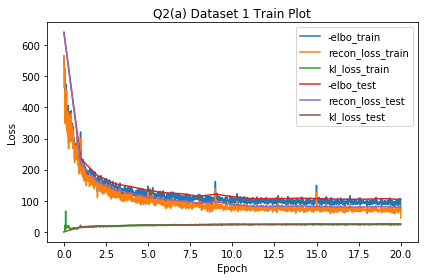

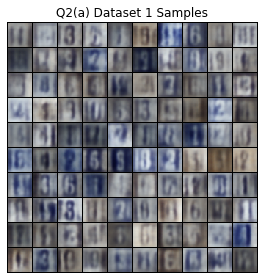

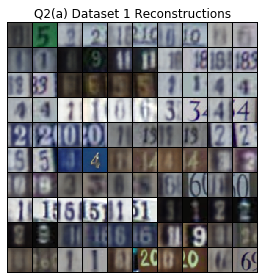

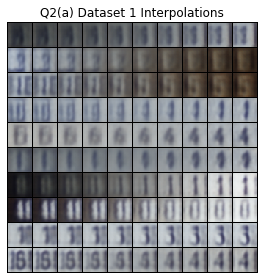

In [ ]:
q2_save_results('a', 1, q2_a)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


init loss [7.91296475e+02 7.91294419e+02 2.05813654e-03]
Epoch 0, Test loss [279.27045137 248.52247808  30.74797278]
Epoch 1, Test loss [250.73316826 218.47286343  32.2603042 ]
Epoch 2, Test loss [247.153971   215.540279    31.61369218]
Epoch 3, Test loss [245.5963791  214.59224004  31.00413959]
Epoch 4, Test loss [243.74632686 213.30910122  30.43722684]
Epoch 5, Test loss [242.37132642 211.60223779  30.76908799]
Epoch 6, Test loss [241.62353262 211.54997812  30.07355404]
Epoch 7, Test loss [240.91991504 208.9033793   32.01653542]
Epoch 8, Test loss [240.77619404 210.12110605  30.65508837]
Epoch 9, Test loss [239.30838428 208.5866291   30.72175609]
Epoch 10, Test loss [239.64522451 208.42179053  31.22343242]
Epoch 11, Test loss [239.73789868 208.86562285  30.87227602]
Epoch 12, Test loss [238.9015332  208.22835884  30.67317496]
Epoch 13, Test loss [241.54182769 210.9870957   30.55473145]
Epoch 14, Test loss [238.95210679 208.23941069  30.71269626]
Epoch 15, Test loss [238.86240439 207.

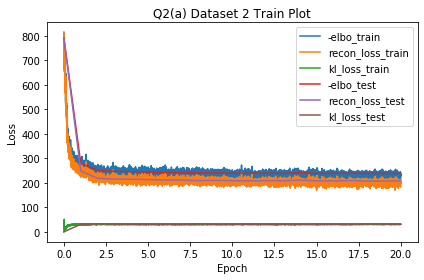

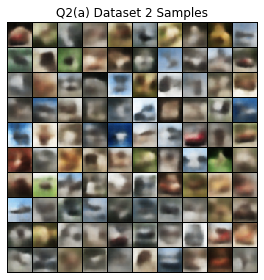

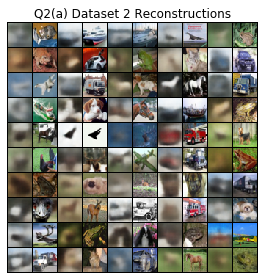

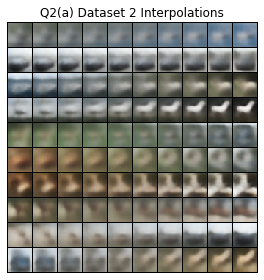

In [ ]:
q2_save_results('a', 2, q2_a)






## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def input_mask(input_dim, hidden_dim): 
  ms = np.random.choice(np.arange(0, input_dim), hidden_dim)
  print(ms) # 512 random numbers between (1, input_dim-1)
  mask = np.zeros((hidden_dim, input_dim))
  for i in range(hidden_dim): 
    for j in range(input_dim):
      if ms[i] >= j :
        mask[i, j] = 1


  hidden_mask = np.zeros((input_dim, hidden_dim))
  for i in range(input_dim): 
    for j in range(hidden_dim): 
      if i > ms[j]: 
        hidden_mask[i, j] = 1
  print(hidden_mask@mask)


  return mask, hidden_mask

input_mask(16, 512)

[ 6 11  1  5 11  0  5  0  2  3 10 11  8 12 15  4  7  2 14  8 12  1  4 10
  8 10  2 12 15 15 11 12  0 13  7  1  9 12 11  9 13  5 15  7  3 13  1  0
 10 14  4 13  6 10  5  1 12  6  6  3 11  9  9  6 12  2  9 14  4 10  5 11
  9 15  3  5  6  6 11  4 15  2  0 10 13  1 12 10  0 12 12 13  8 15  2 13
  0 12 14  8  9  0  9  1 11 13  2  9  6  9  0  4 12 11 14 10  6  4  3  1
  7 13  6  4  0  9  7 15 14 13  6  7  7  9  5 12  9  0  3  8 11  7  8  1
  9 14 14  5 12  0  7 10  8  6 11  8  5 11 11 12  5  9  6  6 13 14  9  2
  3  5 12  2 10 11  5 11  9  3  8  2  2  4  3 14  3 14  9  9  6  9  6 14
  0  0  7  7  8 10  4  5  3  8 11  4  9  7  2  0  4 10  4  5  2  2  7  0
  6  9  8 10  6  3  4 13  1  5 14 12 13  9 12 12 14  1  3  3  1 10  8  5
 15  7 10  2  7  2  8  4  9 10  7  1  8  4 12  3 14 11 11  7  7  7  5  5
  4  1 15 12  1  3 15 11  6  9  3  0  7  5 14  9  6  6 14 12  7  2  4 14
  8 11  6 13 14 13 12  2  3 10  4  0  8  1  2 15  4 12 15 12  5  6 13 15
 10  8 12 14 13  7 11 13  7  2  2 13  5 15 11  0  6

(array([[1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 0., 0., 0.],
        [1., 1., 0., ..., 0., 0., 0.]]), array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 1., ..., 1., 0., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [ ]:
def deepmade(input_dim, hidden1_dim, hidden2_dim): 
  m1 = np.random.choice(np.arange(0, input_dim), hidden1_dim)
  # print(m1) # 512 random numbers between (1, input_dim-1)
  mask = np.zeros((hidden1_dim, input_dim))
  for i in range(hidden1_dim): 
    for j in range(input_dim):
      if m1[i] >= j :
        mask[i, j] = 1


  m2 = np.random.choice(np.arange(0, input_dim), hidden2_dim)
  hidden1_mask = np.zeros((hidden2_dim, hidden1_dim))
  for i in range(hidden2_dim): 
    for j in range(hidden1_dim): 
      if m2[i] >= m1[j]: 
        hidden1_mask[i, j] = 1
  
  # print('intermediate', hidden1_mask@mask)
  hidden2_mask = np.zeros((input_dim, hidden2_dim))
  for i in range(input_dim):
    for j in range(hidden2_dim): 
      if i > m2[j]: 
        hidden2_mask[i, j] = 1

  # print(hidden2_mask@hidden1_mask@mask)
  # plt.imshow(hidden2_mask@hidden1_mask@mask)
  return mask, hidden1_mask, hidden2_mask

m1, m2, m3 = deepmade(16, 512, 512)



In [ ]:
def input_mask(input_dim, hidden_dim): 
  ms = np.random.choice(np.arange(0, input_dim), hidden_dim)
  print(ms) # 512 random numbers between (1, input_dim-1)
  mask = np.zeros((hidden_dim, input_dim))
  for i in range(hidden_dim): 
    for j in range(input_dim):
      if ms[i] >= j :
        mask[i, j] = 1

  hidden_mask = np.zeros((input_dim, hidden_dim))
  for i in range(input_dim): 
    for j in range(hidden_dim): 
      if i > ms[j]: 
        hidden_mask[i, j] = 1
  print(hidden_mask@mask)
  return mask, hidden_mask

input_mask(16, 512)

In [ ]:
latent_dim = 16

class MaskedLinearLayer(nn.Linear): 
  def __init__(self, input_dim, output_dim, mask): 
    super().__init__(input_dim, output_dim, bias=True)
    # self.mask = (np.ones((input_dim, output_dim))*np.triu(np.ones((input_dim, output_dim)), k=1)).T
    # print('masked linear shape', self.mask.shape)
    self.mask = torch.tensor(mask).float().cuda()
    print(self.mask.shape, self.weight.data.shape)
  def forward(self, input): 
    self.weight.data *= self.mask
    return F.linear(input, self.weight, self.bias)

class MADEAF(nn.Module): 
  def __init__(self): 
    super(MADEAF, self).__init__()
    m1, m2, m3 = deepmade(16, 512, 512)
    self.lay1 = MaskedLinearLayer(latent_dim, 512, m1)
    self.lay2 = MaskedLinearLayer(512, 512, m2)
    self.lay3 = MaskedLinearLayer(512, latent_dim, m3)

    self.varlay1 = MaskedLinearLayer(latent_dim, 512, m1)
    self.varlay2 = MaskedLinearLayer(512, 512, m2)
    self.varlay3 = MaskedLinearLayer(512, latent_dim, m3)

  def forward(self, z): 
    loc = F.relu(self.lay1(z))
    loc = F.relu(self.lay2(loc))
    loc = self.lay3(loc)

    log_scale = F.relu(self.varlay1(z))
    log_scale = F.relu(self.varlay2(log_scale))
    log_scale = self.varlay3(log_scale)
    return loc, log_scale

class VAEAF(nn.Module): 
  def __init__(self):
    super(VAEAF, self).__init__()
    self.enc = encoder()
    self.dec= decoder()
    self.madeaf = MADEAF()
    self.mse = nn.MSELoss(size_average=False, reduce=False, reduction='none')

  def repam(self, mu, log_var):
    var = torch.exp(.5*log_var)
    z = mu + var*torch.randn(mu.shape).cuda()
    return z

  def forward(self, x): 
    mu, log_var = self.enc(x)
    z = self.repam(mu, log_var)
    loc, log_scale = self.madeaf(z)
    scale = torch.exp(log_scale)
    eps = ((z*scale) + loc)
    dec_mu = self.dec(z)
    return mu, log_var, dec_mu, log_scale, loc, z, eps

  def loss(self, x, mu, log_var, dec_mu, log_scale, loc, z, eps):  
    # log(q(z|x))
    var = torch.exp(log_var)
    top = -.5*torch.sum((z-mu)*(1/var)*(z-mu), dim=1)
    bottom = .5*torch.sum(log_var, dim=1) + 8*torch.log(torch.tensor(2*np.pi).float().cuda())
    qzx = top - bottom 

    # log(p(eps))
    top = -.5*torch.sum(eps.pow(2), dim=1)
    bottom = 8*torch.log(torch.tensor(2*np.pi).float().cuda())
    peps = top - bottom

    logdet = torch.sum(log_scale, dim=1)

    KL_loss = qzx - peps - logdet
    KL_loss = torch.sum(KL_loss)/x.shape[0]
    # logdet(depsilon/dz)

    recon_loss = self.mse(x, dec_mu)
    recon_loss = torch.sum(recon_loss)/x.shape[0]
    loss = KL_loss + recon_loss
    return loss

  def get_elbo_recon_kl(self, x, mu, log_var, dec_mu, log_scale, loc, z, eps):
    # log(q(z|x))
    var = torch.exp(log_var)
    top = -.5*torch.sum(((z-mu)*(1/var)*(z-mu)), dim=1)
    bottom = .5*torch.sum(log_var, dim=1) + 8*torch.log(torch.tensor(2*np.pi).float().cuda())
    qzx = top - bottom 

    # log(p(eps))
    top = -.5*torch.sum(eps.pow(2), dim=1)
    bottom = 8*torch.log(torch.tensor(2*np.pi).float().cuda())
    peps = top - bottom

    logdet = torch.sum(log_scale, dim=1)

    KL_loss = qzx - peps - logdet
    KL_loss = torch.sum(KL_loss)/x.shape[0]
    # logdet(depsilon/dz)
    recon_loss = self.mse(x, dec_mu)
    recon_loss = torch.sum(recon_loss)/x.shape[0]
    loss = KL_loss + recon_loss
    return loss, recon_loss, KL_loss

  def get_samples(self): 
    self.eval()
    epsilons = torch.randn(100, latent_dim).float().cuda()
    zs = torch.zeros(100, latent_dim).float().cuda()

    for feat in range(latent_dim): 
      print(feat)
      loc, logvar = self.madeaf(zs)
      iaf = (epsilons - loc)*torch.exp(-logvar)
      zs[:, feat] = iaf[:, feat]
    print(loc.shape, logvar.shape)
    print(zs[0])
    zs = (epsilons - loc)*torch.exp(-logvar)
    print(zs[0])
    self.eval()
    samps = self.dec(zs)
    return samps

  def get_test_samples(self, x): 
    x = x.float().cuda()
    mu, log_var = self.enc(x)
    z = self.repam(mu, log_var)
    dec_mu = self.dec(z)
    dec_mu = torch.stack((dec_mu, x))
    dec_mu = dec_mu.permute(1, 0, 2, 3, 4)
    dec_mu = dec_mu.reshape(100, 3, 32, 32)
    return dec_mu

  def interpolations(self, images_1, images_2):
    mu1, logvar1 = self.enc(images_1.float().cuda())
    z1 = self.repam(mu1, logvar1)
    mu2, logvar2 = self.enc(images_2.float().cuda())
    z2 = self.repam(mu2, logvar2)
    dz = z1-z2

    mus_list = []
    for a in range(10): 
      z = z1- (a/9)*dz
      mus = self.dec(z).detach().cpu().numpy()
      mus_list.append(mus)

    mus_list = np.asarray(mus_list)
    print(mus_list.shape) # 10, 10, 3, 32, 32
    mus_list = np.transpose(mus_list, (1, 0, 2, 3, 4))
    mus_list = np.reshape(mus_list, (100, 3, 32, 32))
    mus_list = np.transpose(mus_list, (0, 2, 3, 1))
    return mus_list

def preprocess(data): 
  """preprocess the data to between -1, 1 """
  scale = (data/255)*2 - 1 # B, H, W, C
  perm = scale.permute(0, 3, 1, 2) # B, C, H, W
  return perm

def postprocess(data):
  unscale = ((data + 1)/2)*255 # B, C, H, W
  unperm = unscale.permute(0, 2, 3, 1) #B, H, W, C
  return unperm


In [ ]:
quiet = False

def train(model, train_loader, optimizer, epoch): 
  model.train()
  train_losses = []
  for x in train_loader: 
    x = x.cuda().contiguous()
    mu, log_var, dec_mu, log_scale, loc, z, eps = model(x)
    loss = model.loss(x, mu, log_var, dec_mu, log_scale, loc, z, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu, log_scale, loc, z, eps)
    ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
    train_losses.append(ish)
  return train_losses

def eval_loss(model, data_loader): 
  model.eval()
  total_loss = np.zeros(3)
  with torch.no_grad(): 
    for x in data_loader: 
      x = x.cuda().contiguous()
      mu, log_var, dec_mu, log_scale, loc, z, eps = model(x)
      ish = model.get_elbo_recon_kl(x, mu, log_var, dec_mu, log_scale, loc, z, eps)
      ish = np.asarray([ish[0].cpu(), ish[1].cpu(), ish[2].cpu()])
      total_loss += ish*x.shape[0]
    avg_loss = total_loss/len(data_loader.dataset)
  return avg_loss

def train_epochs(model, train_loader, test_loader, train_args): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  init_loss = eval_loss(model, test_loader)
  print('init loss', init_loss)
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs): 
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet: 
      print(f'Epoch {epoch}, Test loss', test_loss)
  return train_losses, test_losses

In [ ]:
def q2_b(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
            used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
  and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
  - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
  and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
  - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
  FROM THE TEST SET with values in {0, ..., 255}
  - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
  pairs of test images. The output should be those 100 images flattened into
  the specified shape with values in {0, ..., 255}
  """

  """ YOUR CODE HERE """

  train_data = torch.tensor(train_data).float()
  test_data = torch.tensor(test_data).float()

  train_data = preprocess(train_data)
  test_data = preprocess(test_data)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = VAEAF()
  model = model.cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader,test_loader, 
                                          dict(epochs=19, lr=1e-3))

  # samples 
  model.eval()
  samps = model.get_samples()
  samps = postprocess(samps)
  samps = samps.detach().cpu().numpy()

  # real/recon. 
  model.eval()
  real_recon = model.get_test_samples(test_data[:50])
  real_recon = postprocess(real_recon)
  real_recon = real_recon.detach().cpu().numpy()


  # interpolations 
  model.eval()
  images_1 = test_data[:10]
  images_2 = test_data[10:20]
  interps = model.interpolations(images_1, images_2)
  interps = ((interps+1)/2)*255

  return np.asarray(train_losses), np.asarray(test_losses), samps, real_recon, interps

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

torch.Size([512, 16]) torch.Size([512, 16])
torch.Size([512, 512]) torch.Size([512, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([512, 16]) torch.Size([512, 16])
torch.Size([512, 512]) torch.Size([512, 512])
torch.Size([16, 512]) torch.Size([16, 512])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


init loss [6.46563463e+02 6.46530370e+02 3.30926998e-02]
Epoch 0, Test loss [254.53823757 243.89688862  10.64134873]
Epoch 1, Test loss [169.41375186 156.72400076  12.68975098]
Epoch 2, Test loss [148.40073477 134.44068118  13.9600528 ]
Epoch 3, Test loss [142.50310638 127.36179541  15.1413108 ]
Epoch 4, Test loss [132.6863965  115.48583806  17.20055754]
Epoch 5, Test loss [131.66265496 113.44393727  18.21871803]
Epoch 6, Test loss [124.68142883 105.01002813  19.67140168]
Epoch 7, Test loss [120.90041201 101.13687257  19.76353998]
Epoch 8, Test loss [113.73478821  93.65845759  20.07633067]
Epoch 9, Test loss [112.18406304  90.89785988  21.28620321]
Epoch 10, Test loss [109.45732207  87.46382236  21.9934998 ]
Epoch 11, Test loss [111.69540096  89.69540042  22.00000104]
Epoch 12, Test loss [105.87431882  83.92884824  21.9454697 ]
Epoch 13, Test loss [105.17412997  82.83667926  22.33745056]
Epoch 14, Test loss [104.26679064  81.32013831  22.94665223]
Epoch 15, Test loss [103.61651962  80.

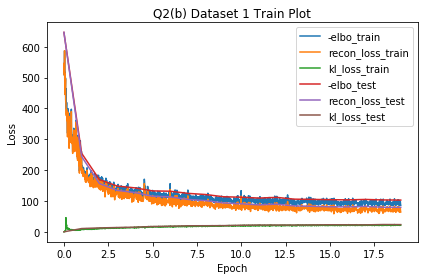

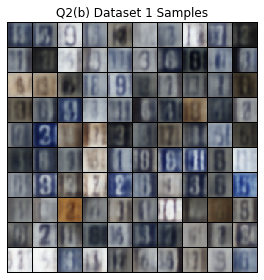

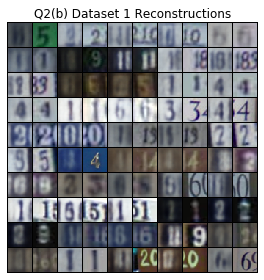

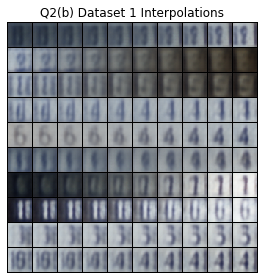

In [ ]:
q2_save_results('b', 1, q2_b)

torch.Size([512, 16]) torch.Size([512, 16])
torch.Size([512, 512]) torch.Size([512, 512])
torch.Size([16, 512]) torch.Size([16, 512])
torch.Size([512, 16]) torch.Size([512, 16])
torch.Size([512, 512]) torch.Size([512, 512])
torch.Size([16, 512]) torch.Size([16, 512])


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


init loss [7.78377542e+02 7.78341295e+02 3.62482026e-02]
Epoch 0, Test loss [275.96924204 248.87667847  27.09256232]
Epoch 1, Test loss [248.74384336 220.52219785  28.22164458]
Epoch 2, Test loss [246.78281699 217.49244019  29.29037697]
Epoch 3, Test loss [243.66273887 214.62578291  29.0369556 ]
Epoch 4, Test loss [242.74114053 213.51460293  29.22653859]
Epoch 5, Test loss [240.9511686  212.26682852  28.6843411 ]
Epoch 6, Test loss [240.48812246 211.77324702  28.71487485]
Epoch 7, Test loss [239.17932842 211.01128447  28.16804398]
Epoch 8, Test loss [237.764352   208.67876719  29.08558535]
Epoch 9, Test loss [237.7653167  208.6634624   29.10185379]
Epoch 10, Test loss [237.59268945 208.9270522   28.6656371 ]
Epoch 11, Test loss [237.17650908 207.70097356  29.47553542]
Epoch 12, Test loss [239.15446299 210.42050488  28.73395821]
Epoch 13, Test loss [237.41648989 208.84179902  28.57469081]
Epoch 14, Test loss [237.1062333  208.17878711  28.9274468 ]
Epoch 15, Test loss [236.36062568 207.

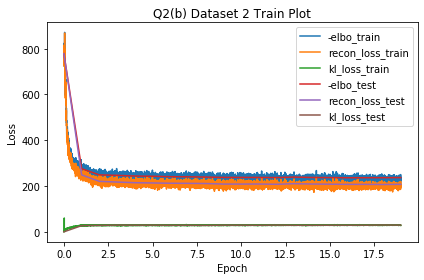

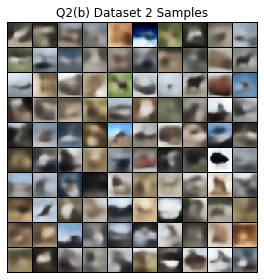

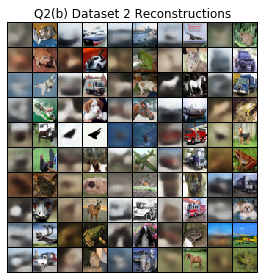

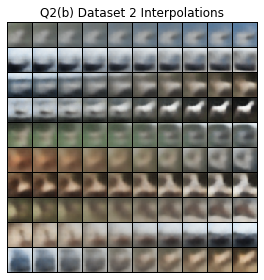

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class resblock(nn.Module): 
  def __init__(self, dim): 
    super(resblock, self).__init__()
    self.bn = nn.BatchNorm2d(dim)
    self.c1 = nn.Conv2d(dim, dim, 3, 1, 1)
    self.bn2 = nn.BatchNorm2d(dim)
    self.c2 = nn.Conv2d(dim, dim, 1, 1, 0)
  def forward(self, x): 
    return x
    h = x
    h = self.bn(h)
    h = F.relu(h)
    h = self.c1(h)
    h = self.bn(h)
    h = F.relu(h)
    h = self.c2(h)
    return h + x


class encoder(nn.Module): 
  def __init__(self):
    super(encoder, self).__init__()
    # conv2d(3, 256, 4, 2, 1) 16 x 16
    # batch_norm2d(256)
    # relu()
    # conv2d(256, 256, 4, 2, 1) 8 x 8
    # residual_block(256)
    # residual_block(256)
    self.c1 = nn.Conv2d(3, 256, 4, 2, 1) # 16 x 16
    self.bn = nn.BatchNorm2d(256)
    self.c2 = nn.Conv2d(256, 256, 4, 2, 1) # 8x8
    self.res_block_1 = resblock(256)
    self.res_block_2 = resblock(256)

  def forward(self, x): 
    x = self.c1(x)
    x = self.bn(x)
    x = F.relu(x)
    x = self.c2(x)
    x = self.res_block_1(x)
    x = self.res_block_2(x)
    return x
    
class decoder(nn.Module): 
  # Decoder
  #   residual_block(256)
  #   residual_block(256)
  #   batch_norm2d(256)
  #   relu()
  #   transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
  #   batch_norm2d(256)
  #   relu()
  #   transpose_conv2d(256, 3, 4, 2, 1) 32 x 32

  def __init__(self): 
    super(decoder, self).__init__()
    self.resb1 = resblock(256)
    self.resb2 = resblock(256)
    self.bn = nn.BatchNorm2d(256)
    self.c1 = nn.ConvTranspose2d(256, 256, 4, 2, 1) #16x16
    self.bn2 = nn.BatchNorm2d(256)
    self.c2 = nn.ConvTranspose2d(256,3, 4, 2, 1)

  def forward(self, x): 
    x = self.resb1(x)
    x = self.resb2(x)
    x = self.bn(x)
    x = F.relu(x)
    x = self.c1(x)
    x = self.bn2(x)
    x = F.relu(x)
    x = self.c2(x)
    x = torch.tanh(x)
    return x # scale to [-1, 1]

def preprocess(data): 
  """preprocess the data to between -1, 1 """
  scale = (data/255)*2 - 1 # B, H, W, C
  perm = scale.permute(0, 3, 1, 2) # B, C, H, W
  return perm

def postprocess(data):
  unscale = ((data + 1)/2)*255 # B, C, H, W
  unperm = unscale.permute(0, 2, 3, 1) #B, H, W, C
  return unperm

In [ ]:
class VQVAE(nn.Module):
  def __init__(self):
    super(VQVAE, self).__init__()
    self.enc = encoder()
    self.dec = decoder()
    # K = 128, D = 256
    # self.codes = torch.rand((128, 256), requires_grad=True).float().cuda() #[0,1]
    # self.codes = (self.codes*2 - 1)/128 
    self.codes = nn.Embedding(128, 256)
    self.codes.weight.data = ((((torch.rand((128, 256), requires_grad=True).float().cuda())*2)-1)/128)
    self.mse = nn.MSELoss(size_average=False, reduce=False, reduction='none')

  def forward(self, x): 
    z_e = self.enc(x)
    # zquant = torch.(self.codes-z).argmin
    z_e_shape = z_e.shape
    z_ = z_e.permute(0, 2, 3, 1).contiguous()
    z_ = z_.contiguous().reshape(-1, 256)
    dists = torch.sum(z_**2, dim=1, keepdim=True) + -2*torch.matmul(z_, self.codes.weight.T) + torch.sum(self.codes.weight**2, dim=1)
    encodings = torch.argmin(dists, dim=1, keepdim=True)
    z_q = self.codes.weight[encodings[:, 0]]
    z_q = z_q.contiguous().view(z_e_shape[0], z_e_shape[2], z_e_shape[3], 256) # BHWC
    z_q = z_q.contiguous().permute(0, 3, 1, 2).contiguous()

    z_q_l = z_q.detach()
    z_e_l = z_e.detach()

    # VQ loss.
    vq_loss = torch.sum((z_e_l.detach() - z_q)**2)/x.shape[0]

    # Commitment loss
    commitment_loss = torch.sum((z_e- z_q_l.detach())**2)/x.shape[0]
    beta = 1.0

    recon = self.dec((z_q_l - z_e_l).detach() + z_e)
    recon_loss = self.mse(x, recon)
    recon_loss = torch.sum(recon_loss)/(x.shape[0])

    loss = recon_loss + vq_loss + beta*commitment_loss
    loss = loss/(x.shape[1]*x.shape[2]*x.shape[3])
  
    return recon, z_q, z_e, loss

  def categorical_latents(self, x): 
    with torch.no_grad(): 
      z_e = self.enc(x)
      z_e_shape = z_e.shape
      z_ = z_e.permute(0, 2, 3, 1).contiguous()
      z_ = z_.contiguous().reshape(-1, 256)
      dists = torch.sum(z_**2, dim=1, keepdim=True) + -2*torch.matmul(z_, self.codes.weight.T) + torch.sum(self.codes.weight**2, dim=1)
      encodings = torch.argmin(dists, dim=1, keepdim=True)
      # Ok so now we need to reshape into (BS, 8, 8, 1)
      encodings = encodings.view(z_e_shape[0], z_e_shape[2], z_e_shape[3], 1)
      encodings = encodings.permute(0, 3, 1, 2)
      return encodings

  def sample_from_test(self, x): 
    self.eval()
    with torch.no_grad():
      z_e = self.enc(x.float().cuda())
      z_e_shape = z_e.shape
      z_ = z_e.permute(0, 2, 3, 1).contiguous()
      z_ = z_.contiguous().reshape(-1, 256)
      dists = torch.sum(z_**2, dim=1, keepdim=True) + -2*torch.matmul(z_, self.codes.weight.T) + torch.sum(self.codes.weight**2, dim=1)
      encodings = torch.argmin(dists, dim=1, keepdim=True)
      z_q = self.codes.weight[encodings[:, 0]]
      z_q = z_q.contiguous().view(z_e_shape[0], z_e_shape[2], z_e_shape[3], 256) # BHWC
      z_q = z_q.contiguous().permute(0, 3, 1, 2).contiguous()

      z_q_l = z_q.detach()
      z_e_l = z_e.detach()

      # VQ loss.
      vq_loss = torch.sum((z_e_l.detach() - z_q)**2)/x.shape[0]

      # Commitment loss
      commitment_loss = torch.sum((z_e- z_q_l.detach())**2)/x.shape[0]
      beta = 1.0

      recon = self.dec((z_q_l - z_e_l).detach() + z_e)
      dec_mu = torch.stack((recon, x.float().cuda()))
      dec_mu = dec_mu.permute(1, 0, 2, 3, 4)
      dec_mu = dec_mu.reshape(100, 3, 32, 32)
      return dec_mu

  def sample_from_pixel_cnn(self, encodings): 
    self.eval()
    with torch.no_grad(): 
    # Re shape the encodings. 
      print(encodings[0])
      encodings = encodings.long()
      og_shape = encodings.shape # B, 8, 8
      encodings = encodings.view(encodings.shape[0]*encodings.shape[1]*encodings.shape[2], 1)
      z_q = self.codes.weight[encodings[:, 0]]
      z_q = z_q.contiguous().view(og_shape[0], og_shape[1], og_shape[2], 256) # BHWC
      z_q = z_q.contiguous().permute(0, 3, 1, 2).contiguous()
      recon = self.dec(z_q)
      return recon


In [ ]:
quiet = False

def train(model, train_loader, optimizer, epoch): 
  model.train()
  train_losses = []
  for x in train_loader: 
    x = x.cuda().contiguous()
    recon, z_q, z_e , loss = model(x)
    # loss = model.loss(x, recon, z_q, z_e)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
  return train_losses

def eval_loss(model, data_loader): 
  model.eval()
  total_loss = 0
  with torch.no_grad(): 
    for x in data_loader: 
      x = x.cuda().contiguous()
      recon, z_q, z_e, loss = model(x)
      # loss = model.loss(x, recon, z_q, z_e)
      total_loss += loss*x.shape[0]
    avg_loss = total_loss/len(data_loader.dataset)
  return avg_loss

def train_epochs(model, train_loader, test_loader, train_args): 
  epochs, lr = train_args['epochs'], train_args['lr']
  optimizer = optim.Adam(model.parameters(), lr=lr)
  train_losses = []
  init_loss = eval_loss(model, test_loader)
  print('init loss', init_loss)
  test_losses = [eval_loss(model, test_loader)]
  for epoch in range(epochs): 
    model.train()
    train_losses.extend(train(model, train_loader, optimizer, epoch))
    test_loss = eval_loss(model, test_loader)
    test_losses.append(test_loss)
    if not quiet: 
      print(f'Epoch {epoch}, Test loss', test_loss)
  return np.asarray(train_losses), np.asarray(test_losses)


def make_new_loaders(model, train_loader, test_loader): 
  model.eval()
  train_data = []
  test_data = []
  with torch.no_grad(): 
    for x in train_loader: 
      x = x.cuda().contiguous()
      cat_lat = model.categorical_latents(x).cpu()
      train_data.append(cat_lat)

    for x in test_loader: 
      x = x.cuda().contiguous()
      cat_lat = model.categorical_latents(x).cpu()
      print(cat_lat.shape)
      test_data.append(cat_lat)
  return torch.cat(train_data), torch.cat(test_data)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def get_mask(mask_type, in_channels, out_channels, kernel_size): 
  mask = np.ones((out_channels, in_channels, kernel_size, kernel_size))
  if mask_type == 'A': 
    mask[:, :, kernel_size//2, kernel_size//2:] =0
  else: 
    mask[:, :, kernel_size//2, kernel_size//2 +1:] =0
  mask[:, :, kernel_size//2 +1:, :] = 0
  return mask
  
class MaskedConv2D(nn.Conv2d): 
  def __init__(self, in_channels, out_channels, kernel_size, mask_type, bias=True): 
    super().__init__(in_channels, out_channels, kernel_size, padding=(kernel_size-1)//2)
    self.mask = get_mask(mask_type, in_channels, out_channels, kernel_size)
    self.mask = torch.tensor(self.mask).float().cuda()
    self.padding = kernel_size-1
    self.padding = self.padding//2
  def forward(self, input):
    self.weight.data *= self.mask
    return F.conv2d(input, self.weight, self.bias, padding=self.padding)
  
class ResidualMaskedConv2D(nn.Module): 
  def __init__(self, in_channels, out_channels, kernel_size, mask_type, bias=True): 
    super(ResidualMaskedConv2D, self).__init__()
    self.masked_conv = MaskedConv2D(out_channels, out_channels, kernel_size, mask_type, bias)
    self.conv_in = torch.nn.Conv2d(in_channels, out_channels, 1)
    self.conv_out = torch.nn.Conv2d(out_channels, out_channels, 1)
    self.lnorm = torch.nn.BatchNorm2d(out_channels)
  def forward(self, x):
    residual = x
    layer_1 = F.relu(self.conv_in(x))
    layer_2= F.relu(self.masked_conv(layer_1))
    layer_3 = F.relu(self.conv_out(layer_2))
    layer_3 = self.lnorm(layer_3)
    out = layer_3 + residual
    return out

class PixelCNN(nn.Module): 
  def __init__(self): 
    super(PixelCNN, self).__init__()
    self.emb = nn.Embedding(128, 64)
    self.m1 = MaskedConv2D(64, 120, 7, 'A', bias=True)
    self.m2 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m3 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m4 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m5 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m6 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m7 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m8 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m9 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m10 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m11 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m12 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m1225 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m125 = ResidualMaskedConv2D(120, 120, 7, 'B')
    self.m13 = torch.nn.Conv2d(120, 512, 1)
    self.m14 = torch.nn.Conv2d(512, 128, 1)

  def forward(self, x): 
    targs = x.contiguous()
    x = self.emb(x.long()).contiguous()
    x = x.contiguous().permute(0, 3, 1, 2).contiguous()
    out1 = self.m1(x)
    out2 = self.m2(out1)
    out3 = self.m3(out2)
    out4 = self.m4(out3)
    out5 = self.m5(out4)
    out6 = self.m6(out5)
    out7 = self.m7(out6)
    out8 = self.m8(out7)
    out9 = self.m9(out8)
    out10 = self.m10(out9)
    out11 = self.m11(out10)
    out12 = self.m12(out11)
    out12 = self.m1225(out12)
    out12 = self.m125(out12)
    out13 = self.m13(out12)
    out14 = self.m14(out13)
    out = out14.contiguous() # BS,128,H,W

    loss = F.cross_entropy(out, targs.long()) # yeww. 
    return out, torch.zeros(1), torch.zeros(1), loss # just filling in structure so its same as VQVAE.

  def sample(self): 
    self.eval()
    samples = torch.zeros(100, 8, 8).cuda()
    samples = torch.floor(torch.rand(100, 8, 8)*128).cuda()
    with torch.no_grad():
      for r in range(8):
        for c in range(8):
            logits, _, _, _ = self(samples)
            logits = logits[:, :, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples

In [ ]:
def q3(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
  test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
  - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
  - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
  - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
  - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
  - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
    FROM THE TEST SET with values in [0, 255]
  """


  train_data = torch.tensor(train_data).float()
  test_data = torch.tensor(test_data).float()

  train_data = preprocess(train_data)
  test_data = preprocess(test_data)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = VQVAE()
  model = model.cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader,test_loader, 
                                          dict(epochs=20, lr=1e-3))


  # get the vectors of 2d discrete values. 
  train_data_grid, test_data_grid = make_new_loaders(model, train_loader, test_loader)
  train_data_grid = torch.squeeze(train_data_grid)
  test_data_grid = torch.squeeze(test_data_grid)

  print(train_data_grid.shape, test_data_grid.shape)

  train_loader_grid = data.DataLoader(train_data_grid, batch_size=128, shuffle=True)
  test_loader_grid = data.DataLoader(test_data_grid, batch_size=128)
  # feed those into the pixel CNN.


  pixCNN = PixelCNN()
  pixCNN = pixCNN.cuda()

  pix_train_losses, pix_test_losses = train_epochs(pixCNN, train_loader_grid, test_loader_grid, 
                                           dict(epochs=7, lr=1e-3))
  pixCNN.eval()
  model.eval()
  samples_from_CNN = pixCNN.sample()
  samples = model.sample_from_pixel_cnn(samples_from_CNN)

  pairs = model.sample_from_test(test_data[:50])

  samples = postprocess(samples).detach().cpu().numpy()
  pairs = postprocess(pairs).detach().cpu().numpy()

  return train_losses, test_losses, pix_train_losses, pix_test_losses, samples, pairs


    

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


init loss tensor(0.3167, device='cuda:0')
Epoch 0, Test loss tensor(2.1012, device='cuda:0')
Epoch 1, Test loss tensor(0.3353, device='cuda:0')
Epoch 2, Test loss tensor(0.2632, device='cuda:0')
Epoch 3, Test loss tensor(0.1393, device='cuda:0')
Epoch 4, Test loss tensor(0.1221, device='cuda:0')
Epoch 5, Test loss tensor(0.0997, device='cuda:0')
Epoch 6, Test loss tensor(0.0634, device='cuda:0')
Epoch 7, Test loss tensor(0.0576, device='cuda:0')
Epoch 8, Test loss tensor(0.0632, device='cuda:0')
Epoch 9, Test loss tensor(0.0487, device='cuda:0')
Epoch 10, Test loss tensor(0.0465, device='cuda:0')
Epoch 11, Test loss tensor(0.0550, device='cuda:0')
Epoch 12, Test loss tensor(0.0444, device='cuda:0')
Epoch 13, Test loss tensor(0.0405, device='cuda:0')
Epoch 14, Test loss tensor(0.0438, device='cuda:0')
Epoch 15, Test loss tensor(0.0458, device='cuda:0')
Epoch 16, Test loss tensor(0.0337, device='cuda:0')
Epoch 17, Test loss tensor(0.0407, device='cuda:0')
Epoch 18, Test loss tensor(0.037

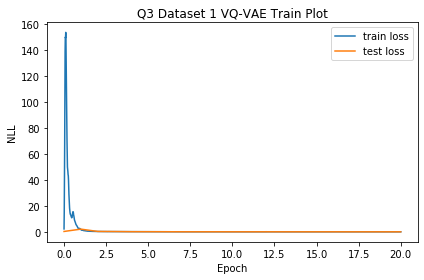

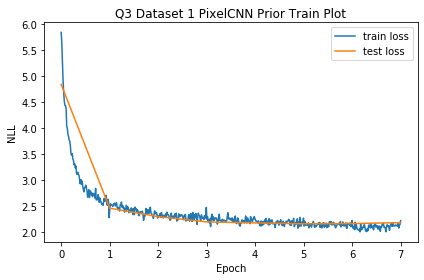

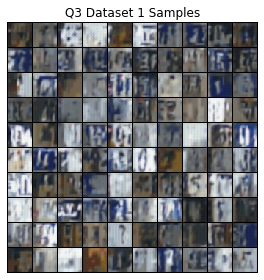

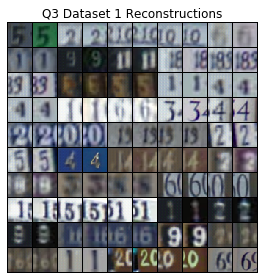

In [ ]:
q3_save_results(1, q3)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


init loss tensor(0.3861, device='cuda:0')
Epoch 0, Test loss tensor(0.1656, device='cuda:0')
Epoch 1, Test loss tensor(0.1067, device='cuda:0')
Epoch 2, Test loss tensor(0.0905, device='cuda:0')
Epoch 3, Test loss tensor(0.0816, device='cuda:0')
Epoch 4, Test loss tensor(0.0798, device='cuda:0')
Epoch 5, Test loss tensor(0.0733, device='cuda:0')
Epoch 6, Test loss tensor(0.0755, device='cuda:0')
Epoch 7, Test loss tensor(0.0727, device='cuda:0')
Epoch 8, Test loss tensor(0.0735, device='cuda:0')
Epoch 9, Test loss tensor(0.0748, device='cuda:0')
Epoch 10, Test loss tensor(0.0713, device='cuda:0')
Epoch 11, Test loss tensor(0.0750, device='cuda:0')
Epoch 12, Test loss tensor(0.0768, device='cuda:0')
Epoch 13, Test loss tensor(0.0730, device='cuda:0')
Epoch 14, Test loss tensor(0.0712, device='cuda:0')
Epoch 15, Test loss tensor(0.0696, device='cuda:0')
Epoch 16, Test loss tensor(0.0813, device='cuda:0')
Epoch 17, Test loss tensor(0.0726, device='cuda:0')
Epoch 18, Test loss tensor(0.067

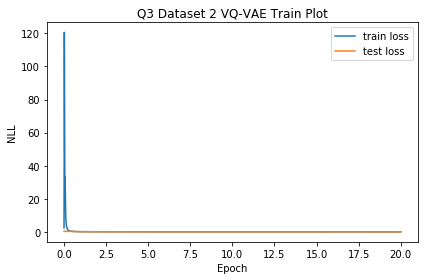

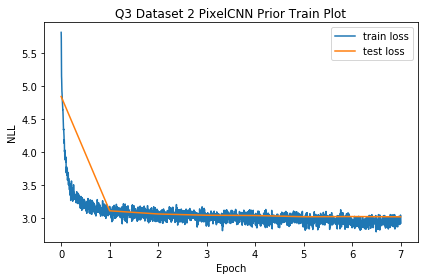

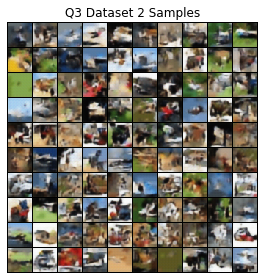

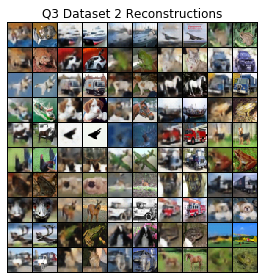

In [ ]:
q3_save_results(2, q3)

# Question 4 Bonus [15pts]

## Part (a) Improving VQ-VAE Results [10pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# def get_mask(mask_type, in_channels, out_channels, kh, kw): 
#   # print('using color masks')
#   mask = np.ones((out_channels, in_channels, kh, kw))
#   mask[:, :, kh//2, kw//2:] =0
#   mask[:, :, kh//2 +1:, :] = 0
def get_mask(mask_type, in_channels, out_channels, kh, kw): 
  mask = np.ones((out_channels, in_channels, kh, kw))
  if mask_type == 'A': 
    mask[:, :, kh//2, kw//2:] =0
  else: 
    mask[:, :, kh//2, kw//2 +1:] =0
  mask[:, :, kh//2 +1:, :] = 0
  return mask
  
class ColorMaskedConv2D(nn.Conv2d): 
  def __init__(self, in_channels, out_channels, kh, kw, mask_type, bias=False): 
    super().__init__(in_channels, out_channels, (kh, kw), padding=((kh-1)//2, (kw-1)//2))
    self.mask = get_mask(mask_type, in_channels, out_channels, kh, kw)
    self.mask = torch.tensor(self.mask).float().cuda()
    self.padding = ((kh-1)//2, (kw-1)//2)
  def forward(self, input):
    # print(self.weight.data.shape, self.mask.shape, input.shape)
    self.weight.data *= self.mask
    return F.conv2d(input, self.weight, padding=self.padding)
  
class GatedConv2D(nn.Module): 
  def __init__(self, in_shape, out_shape, kernel_size, mask_type, bias=False, final_layer=False): 
    super(GatedConv2D, self).__init__()
    n = kernel_size
    self.mask_type = mask_type # for telling if we have the first layer, in which case there is no residual due to dimensionality. 
    self.n_by_n_conv = ColorMaskedConv2D(in_shape, 2*out_shape, n, n, mask_type, bias=False)
    self.one_by_n_conv = ColorMaskedConv2D(in_shape, 2*out_shape, 1, n, mask_type, bias=False)
    # print(self.one_by_n_conv.weight.data.shape)
    self.one_by_one_cross_block = ColorMaskedConv2D(2*out_shape, 2*out_shape, 1, 1, mask_type, bias=False)
    self.final_one_by_one = ColorMaskedConv2D(out_shape, out_shape, 1, 1, mask_type, bias=False)
    self.bn = torch.nn.BatchNorm2d(2*out_shape)
    self.final_layer = final_layer
  def forward(self, x):
    # input is # 120, H, W
    #step 1 split feature maps this does the left side of figure 2. 
    a = x[:, :x.shape[1]//2, :, :]
    a = self.n_by_n_conv(a) # should come out with 2*p
    a_tanh = torch.tanh(a[:, :a.shape[1]//2, :, :])
    a_sigmoid = torch.sigmoid(a[:, a.shape[1]//2:, :, :])
    a_out = a_tanh*a_sigmoid # elementwise multiply. 
    # print('a done')

    # Now doing the right side. 
    b = x[:, x.shape[1]//2:, :, :] 
    if self.mask_type == 'B':  # otherwise in the first layer. 
      residual = b
    h = self.one_by_n_conv(b)
    # print('post one by n')

    #Cross from left. 
    from_left = self.one_by_one_cross_block(a)
    b_p = h + from_left
    b_p_tanh = torch.tanh(b_p[:, :b_p.shape[1]//2, :, :])
    b_p_sig = torch.sigmoid(b_p[:, b_p.shape[1]//2:, :, :])
    c = b_p_tanh*b_p_sig
    d = self.final_one_by_one(c)
    if not self.mask_type == 'A' and self.final_layer == False: 
      d += residual
    out = self.bn(torch.cat([a_out, d], dim=1))
    return out

class GatedPixelCNN(nn.Module): 
  def __init__(self): 
    super(GatedPixelCNN, self).__init__()
    self.emb = nn.Embedding(128, 64)
    self.m1 = GatedConv2D(64, 64, 7, 'A')
    self.m2 = GatedConv2D(64, 64, 7, 'B')
    self.m3 = GatedConv2D(64, 64, 7, 'B')
    self.m4 = GatedConv2D(64, 64, 7, 'B')
    self.m5 = GatedConv2D(64, 64, 7, 'B')
    self.m6 = GatedConv2D(64, 64, 7, 'B')
    self.m7 = GatedConv2D(64, 64, 7, 'B')
    self.m8 = GatedConv2D(64, 64, 7, 'B')
    self.m9 = GatedConv2D(64, 64, 7, 'B')
    self.m10 = GatedConv2D(64, 64, 7, 'B')
    self.m11 = GatedConv2D(64, 64, 7, 'B')
    self.m12 = GatedConv2D(64, 64, 7, 'B')
    self.m13 = GatedConv2D(64, 64, 7, 'B')
    self.m14 = GatedConv2D(64, 64, 7, 'B')
    self.m15 = torch.nn.Conv2d(128, 512, 1)
    self.m16 = torch.nn.Conv2d(512, 128, 1)

  def forward(self, x): 
    # step 1: make x into two copies of x  to feed into the vertical and horizontal stacks. 
    targs = x.contiguous()
    x = self.emb(x.long()).contiguous()
    x = x.contiguous().permute(0, 3, 1, 2).contiguous()
    x = torch.cat([x, x], dim= 1)
    # print(x.shape)
    out1 = self.m1(x)
    out2 = self.m2(out1)
    out3 = self.m3(out2)
    out4 = self.m4(out3)
    out5 = self.m5(out4)
    out6 = self.m6(out5)
    out7 = self.m7(out6)
    out8 = self.m8(out7)
    out9 = self.m9(out8)
    out10 = self.m10(out9)
    out11 = self.m11(out10)
    out12 = self.m12(out11)
    out13 = self.m13(out12)
    out14 = self.m14(out13)
    out15 = self.m15(out14)
    out16 = self.m16(out15)
    out = out16.contiguous() # BS,128,H,W
    loss = F.cross_entropy(out, targs.long())
    return out, torch.zeros(1), torch.zeros(1), loss

  def sample(self): 
    samples = torch.zeros(100, 8, 8).cuda()
    samples = torch.floor(torch.rand(100, 8, 8)*128).cuda()
    with torch.no_grad():
      for r in range(8):
        for c in range(8):
            logits, _, _, _ = self(samples)
            logits = logits[:, :, r, c]
            probs = F.softmax(logits, dim=1)
            samples[:, r, c] = torch.multinomial(probs, 1).squeeze(-1)
    return samples

In [ ]:
def q4_a(train_data, test_data, dset_id):
  """
  train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
  test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
  dset_id: An identifying number of which dataset is given (1 or 2). Most likely
              used to set different hyperparameters for different datasets

  Returns
  - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
  - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
  - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
  - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
  - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
  - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
    FROM THE TEST SET with values in [0, 255]
  """

  """ YOUR CODE HERE """

  train_data = torch.tensor(train_data).float()
  test_data = torch.tensor(test_data).float()

  train_data = preprocess(train_data)
  test_data = preprocess(test_data)

  train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
  test_loader = data.DataLoader(test_data, batch_size=128)

  # model
  model = VQVAE()
  model = model.cuda()

  # train
  train_losses, test_losses = train_epochs(model, train_loader,test_loader, 
                                          dict(epochs=7, lr=1e-3))


  # get the vectors of 2d discrete values. 
  train_data_grid, test_data_grid = make_new_loaders(model, train_loader, test_loader)
  train_data_grid = torch.squeeze(train_data_grid)
  test_data_grid = torch.squeeze(test_data_grid)

  print(train_data_grid.shape, test_data_grid.shape)

  train_loader_grid = data.DataLoader(train_data_grid, batch_size=128, shuffle=True)
  test_loader_grid = data.DataLoader(test_data_grid, batch_size=128)
  # feed those into the pixel CNN.


  pixCNN = GatedPixelCNN()
  pixCNN = pixCNN.cuda()

  pix_train_losses, pix_test_losses = train_epochs(pixCNN, train_loader_grid, test_loader_grid, 
                                           dict(epochs=7, lr=1e-3))
  
  samples_from_CNN = pixCNN.sample()
  samples = model.sample_from_pixel_cnn(samples_from_CNN)

  pairs = model.sample_from_test(test_data[:50])

  samples = postprocess(samples).detach().cpu().numpy()
  pairs = postprocess(pairs).detach().cpu().numpy()

  return train_losses, test_losses, pix_train_losses, pix_test_losses, samples, pairs



### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


init loss tensor(0.4087, device='cuda:0')
Epoch 0, Test loss tensor(0.1742, device='cuda:0')
Epoch 1, Test loss tensor(0.0981, device='cuda:0')
Epoch 2, Test loss tensor(0.0879, device='cuda:0')
Epoch 3, Test loss tensor(0.0800, device='cuda:0')
Epoch 4, Test loss tensor(0.0755, device='cuda:0')
Epoch 5, Test loss tensor(0.0711, device='cuda:0')
Epoch 6, Test loss tensor(0.0747, device='cuda:0')
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.Size([128, 1, 8, 8])
torch.S

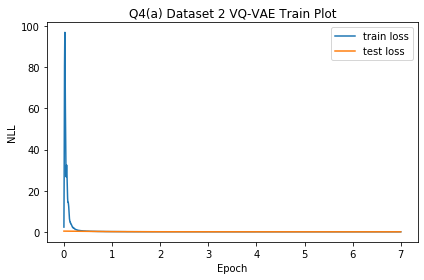

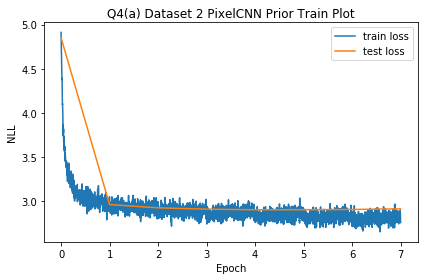

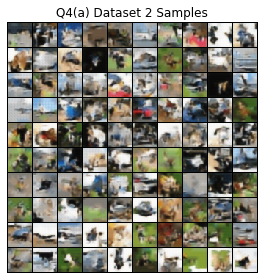

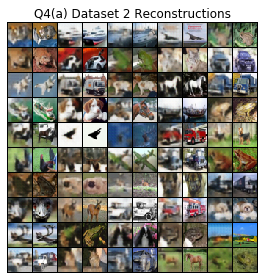

In [ ]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

In [ ]:
q4_b_save_results(q4_b)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)